In [31]:
from fastai.vision.all import *
import sklearn.feature_extraction.text
from transformers import (BertTokenizer, BertModel,
                          AutoConfig, AutoModel)
import gc
import sklearn.feature_extraction.text

In [32]:
from shopee_utils import *

In [33]:
BERT_PATH='bert_indonesian'

In [34]:
image_model_file = 'models/resnet18val0.pth'
bert_model_file = 'models/bert_indo_val0.pth'

In [35]:
train_df = pd.read_csv(PATH/'train.csv')
train_df = add_splits(train_df)

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


## Image Model

In [36]:
class ResnetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = create_body(resnet18, cut=-2, pretrained=False)
        self.after_conv=nn.Sequential(
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.BatchNorm1d(1024)
        )
    def forward(self, x):
        x = self.body(x)
        return self.after_conv(x)

In [37]:
def get_img_file(row):
    img =row.image
    fn  = PATH/'train_images'/img
    if not fn.is_file():
        fn = PATH/'test_images'/img
    return fn
def get_image_dls(size, bs):
    data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 get_y=ColReader('label_group'),
                 get_x=get_img_file,
                 item_tfms=Resize(int(size*1.5), resamples=(Image.BICUBIC,Image.BICUBIC)),
                 #item_tfms=Resize(size, resamples=(Image.BICUBIC,Image.BICUBIC)),
                 batch_tfms=aug_transforms(size=size, min_scale=0.75)+[Normalize.from_stats(*imagenet_stats)],
                 )
    return data_block.dataloaders(train_df, bs=bs)

In [38]:
def load_image_model(fname):
    state_dict = torch.load(fname)
    model = ResnetModel()
    model.load_state_dict(state_dict)
    model = model.eval().cuda()
    return model

## Bert Model

In [39]:
class BertTextModel(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert_model = bert_model
    def forward(self, x):
        output = self.bert_model(*x)
        return output.last_hidden_state[:,0,:]

In [40]:
#Taken from https://www.kaggle.com/c/shopee-product-matching/discussion/233605#1278984
def string_escape(s, encoding='utf-8'):
    return s.encode('latin1').decode('unicode-escape').encode('latin1').decode(encoding)

class TitleTransform(Transform):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained(BERT_PATH)
      
    def encodes(self, row):
        text = row.title
        text=string_escape(text)
        encodings = self.tokenizer(text, padding = 'max_length', max_length=100, truncation=True,return_tensors='pt')
        keys =['input_ids', 'attention_mask', 'token_type_ids'] 
        return tuple(encodings[key].squeeze() for key in keys)

def get_text_dls():
    tfm = TitleTransform()

    data_block = DataBlock(
        blocks = (TransformBlock(type_tfms=tfm), 
                  CategoryBlock(vocab=train_df.label_group.to_list())),
        splitter=ColSplitter(),
        get_y=ColReader('label_group'),
        )
    return  data_block.dataloaders(train_df, bs=256)

In [41]:
def load_bert_model(fname):
    model = AutoModel.from_config(AutoConfig.from_pretrained(BERT_PATH))
    state = torch.load(fname)
    model.load_state_dict(state)
    return BertTextModel(model).cuda().eval()

## TFIDF

In [42]:
def csr_matrix_to_tensor(csr):
    coo = csr.tocoo()
    t = torch.sparse_coo_tensor([coo.row, coo.col], coo.data, csr.shape).cuda()
    return t

def do_chunk_tfidf(embs):
    step = 5000
    for chunk_start in range(0, embs.shape[0], step):
        chunk_end = min(chunk_start+step, embs.shape[0])
        chunk = embs[chunk_start:chunk_end]
        chunk = csr_matrix_to_tensor(chunk).to_dense()
        yield chunk
        
def get_tfid_embs(data, idxs):
    sk_model = sklearn.feature_extraction.text.TfidfVectorizer(stop_words='english', binary=True, max_features=25_000)
    text_embeddings =sk_model.fit_transform(data.title)
    text_embeddings =text_embeddings[idxs]
    return text_embeddings  

def tfidf_get_dist_for_inds(embs, inds):
    step=1000
    dists = []
    for chunk_start in range(0, len(inds), step):
        chunk_end = min(chunk_start+step, len(inds))
        A = embs[chunk_start: chunk_end]
        A = csr_matrix_to_tensor(A).to_dense()
        A = A[:,:,None]
        B = embs[inds[chunk_start:chunk_end].cpu()]
        B = csr_matrix_to_tensor(B).to_dense()
        D = torch.matmul(B,A)
        dists.append(D.squeeze())
    dists = torch.cat(dists)
    return dists

## Helper functions

## Test on Validation set

In [43]:
img_embs,ys = embs_from_model(load_image_model(image_model_file), get_image_dls(224,256).valid)

  0%|          | 0/27 [00:00<?, ?it/s]

In [44]:
bert_embs, ys = embs_from_model(load_bert_model(bert_model_file), get_text_dls().valid)

  0%|          | 0/27 [00:00<?, ?it/s]

In [45]:
#tfid_embs=  get_tfid_embs(train_df, train_df[train_df.is_valid].index.tolist())

In [46]:
#tfid_dists, tfid_inds = get_nearest(csr_matrix_to_tensor(tfid_embs), do_chunk_text(tfid_embs))

In [47]:
img_dists, img_inds = get_nearest(img_embs, do_chunk(img_embs))
bert_dists, bert_inds = get_nearest(bert_embs, do_chunk(bert_embs))

In [48]:
combined_inds = torch.cat([img_inds, bert_inds], dim=1)
combined_inds.shape

torch.Size([6852, 100])

In [49]:
img_dists = get_dist_for_inds(img_embs, combined_inds)
bert_dists = get_dist_for_inds(bert_embs, combined_inds)

In [50]:
combined_dists = img_dists+bert_dists - img_dists*bert_dists

In [51]:
set_size = len(img_embs)
target_matrix= ys[:,None]==ys[None,:]
targets = [torch.where(t)[0].tolist() for t in target_matrix] 

0.883 at 5.936952590942383 pairs or 0.766 threshold


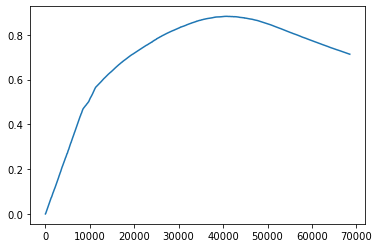

In [52]:
pairs = sorted_pairs(combined_dists, combined_inds)

_=build_from_pairs(pairs[:10*set_size], targets)

In [53]:
groups = [[] for _ in range(set_size)]
for x,y,v in pairs[:int(5.958*set_size)]:
    groups[x].append(y)

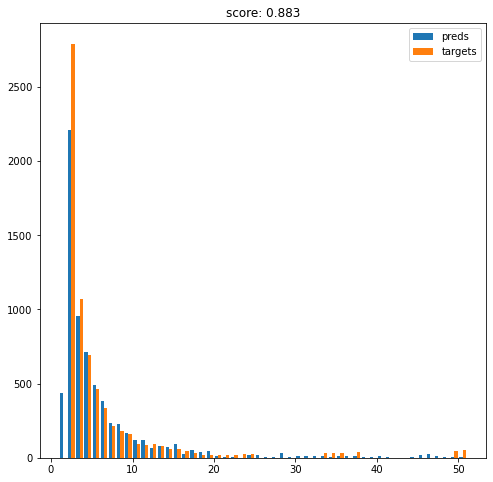

In [54]:
show_groups(groups, targets)

In [55]:
def edges_to_groups(edges, N):
    groups = [[] for i in range(N)]
    groups_p = [[] for _ in range(N)]
    for x,y,v in edges:
        if len(groups[x])>=51 or x==y: continue
        #if len(groups[x])>=51: continue
        groups[x].append(y)
        groups_p[x].append(v)
    return groups, groups_p

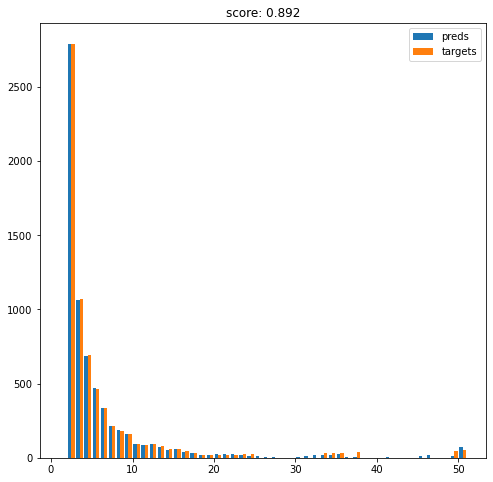

In [56]:
groups, groups_p = edges_to_groups(pairs, set_size)

#
for pos, size_pct in get_targets_shape(train_df):
    chisel(groups, groups_p, pos-1, int(size_pct * len(groups)))
    
groups = [g+[i] for i,g in enumerate(groups)]
show_groups(groups, targets)

In [62]:
def top3(i):
    return torch.tensor([i]+groups[i][:2])

def trip_score(i):
    second = groups[i][0]
#     trip1 = top3(i)
#     trip2 = top3(second)
#     p1 = D[trip1[:,None], trip1[None,:]].min()
#     p2 = D[trip2[:,None], trip2[None,:]].min()
#     return p1+p2-p1*p2

    p1 = groups_p[i][1]
    if groups[second][0] == i:
        p2 = groups_p[second][1]
    else:
        p2= groups_p[second][0]
    return p1+p2-p1*p2

def chisel2(groups, groups_p, target_count):
    ts = torch.tensor([trip_score(i) for i in range(set_size)])
    _, cands = (-ts.cuda()).topk(target_count)
    found = 0
    for i in cands.tolist():
        if len(groups[i]) <= 1: continue
        groups[i]=groups[i][:1]
        groups_p[i]=groups_p[i][:1]
        found +=1
        second = groups[i][0]
        if len(groups[second]) > 1:
            groups[second]=groups[second][:1]
            groups_p[second]=groups_p[second][:1]
            found +=1
        if found >= target_count: break

In [63]:
groups, groups_p = edges_to_groups(pairs, set_size)


In [64]:

for pos, size_pct in get_targets_shape(train_df):
    if pos==2: 
        chisel2(groups, groups_p, int(size_pct * len(groups)))
    else:
        chisel(groups, groups_p, pos-1, int(size_pct * len(groups)))

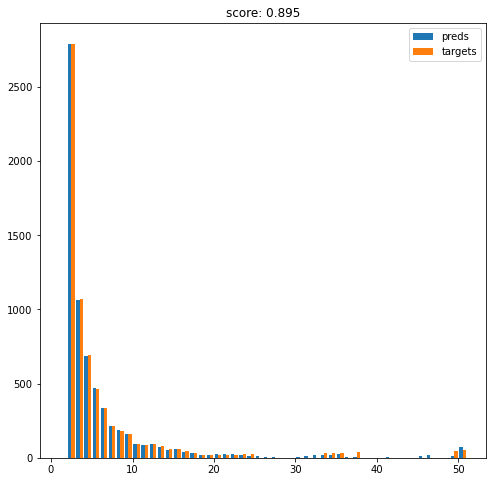

In [65]:
groups = [g+[i] for i,g in enumerate(groups)]
show_groups(groups, targets)

In [270]:
len(list(filter(lambda g:len(g)==2, groups)))

2683

In [229]:
match, mismatch=0,0
for x in used:
    if len(targets[x])==2: match+=1
    else: mismatch +=1
match, mismatch

(2431, 361)

In [ ]:
a.index

In [112]:
ranks=[]
reciprocal=0
for i in range(set_size):
    if len(targets[i])!=2: continue
    second = targets[i][0] if targets[i][1]==i else targets[i][1]
    try:
        r = groups[i].index(second)
    except:
        r=51
    if r==0 and groups[second][0]==i: reciprocal+=1
    ranks.append(r)
reciprocal / len(ranks)

0.8660458452722063

In [109]:
ranks.count(0)/len(ranks)

0.8946991404011462

In [33]:
match, mismatch=0,0
for i in range(len(groups)):
    g = groups[i]
    if len(g)==2:
        second = g[0] if g[1]==i else g[1]
        if set(groups[second]) != set(groups[i]):
            print('mismatch', groups[i], groups[second], targets[i])
            mismatch +=1
        else: match+=1
match, mismatch

mismatch [39, 4243] [4243, 39, 863] [39, 863, 4243]
mismatch [42, 2773] [2773, 6560, 6561, 6558, 6559, 6557, 4913, 4795, 5676, 4080, 1300, 4384, 615, 5115, 3739, 2549, 3315, 5956, 2742, 1219, 1666, 2498, 2744] [42, 3739]
mismatch [45, 4786] [4786, 625] [45, 4786]
mismatch [57, 3561] [3561, 57, 6580] [57, 3561, 6580]
mismatch [61, 6716] [6716, 3975, 4605, 4606, 4607, 61] [61, 5649]
mismatch [71, 2052] [2052, 4987, 3018, 4988, 3626, 3278, 4050, 71, 3887, 3280, 3279, 4614, 5831, 5760, 5627, 857] [71, 2052, 5831]
mismatch [101, 3703] [3703, 5099, 1043, 1690, 5212] [101, 1043, 2490, 3022, 5099, 5212, 5757, 5967]
mismatch [109, 3546] [3546, 109, 283, 2128, 1023] [109, 283, 1023, 2128, 3546]
mismatch [779, 111] [779, 111, 310] [111, 310, 779]
mismatch [126, 462] [462, 2085] [126, 462, 1849, 1985, 2085, 4147, 4976]
mismatch [131, 6117] [6117, 3096, 131] [131, 3096, 6117]
mismatch [150, 4557] [4557, 373] [150, 4557]
mismatch [162, 4440] [4440, 162, 4038] [162, 4440]
mismatch [192, 3012] [3012, 

(2262, 530)

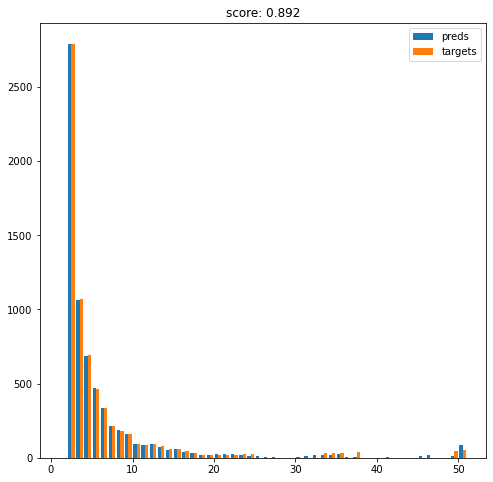

In [28]:
show_groups(groups, targets)